# Fit 3 sentiment models-
- spacytextblob
- bert
- vader

### Setup

In [1]:
# !python -m spacy download en_core_web_sm
# !pip install spacytextblob
# !pip install vaderSentiment
# !pip install torch

In [2]:
import pandas as pd
import gcsfs
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from google.cloud import storage
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
2024-11-16 16:38:18.851431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731775099.144568    4527 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731775099.231479    4527 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-16 16:38:19.997746: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the ap

In [3]:
fs = gcsfs.GCSFileSystem()

path = f'gs://amazon-home-and-kitchen/full_train_data_txt_processed.csv'
df = pd.read_csv(path, dtype={'price': float,'subtitle': str }, na_values=['—'], nrows=1000)     # ONLY READING 1000 ROWS, REMOVE FOR DATA PROCESSING STEP
df['processed_text'] = df['processed_text'].astype(str)

### Fit models

In [4]:
# Apply TextBlob sentiment analysis
df['sentiment_text_blob'] = df['processed_text'].apply(lambda text: TextBlob(text).sentiment.polarity)

In [5]:
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis to get scores from -1 to 1
df['sentiment_vader'] = df['processed_text'].apply(lambda text: sia.polarity_scores(text)['compound'])


In [6]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from scipy.special import softmax

# Load pre-trained BERT model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

def get_sentiment_score(text):
    # Tokenize and get model outputs
    inputs = tokenizer(text, return_tensors="tf", truncation=True, max_length=512)  # Changed to 'tf'
    outputs = model(**inputs)
    scores = outputs.logits.numpy()  # No need for .detach() with TensorFlow

    # Apply softmax to get probabilities and map them to -1, 0, or 1
    probs = softmax(scores[0])
    sentiment_score = probs[4] - probs[0]  # High negative to high positive

    return sentiment_score

# Apply the function to the processed_text column
df['sentiment_bert'] = df['processed_text'].apply(get_sentiment_score)


2024-11-16 16:38:29.582356: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [7]:
df.head()

,main_category,title_x,average_rating,rating_number,features,description,price,images_x,videos,store,...,images_y,asin,user_id,timestamp,helpful_vote,verified_purchase,processed_text,sentiment_text_blob,sentiment_vader,sentiment_bert
0,Amazon Home,jersey seating 2 x Vinyl Air Lift Adjustable S...,4.3,167,"['Sleek chrome metal base, seat covered in Red...",[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Small and Stylish Barstools ', 'ur...",jersey seating®,...,[],B00KKU8HVE,AHED326L5JZMCI2GAXFXNKZGQKNA,2015-07-24 14:37:07.000,0,True,nice,0.600000,0.4215,0.412663
1,Amazon Home,jersey seating 2 x Vinyl Air Lift Adjustable S...,4.3,167,"['Sleek chrome metal base, seat covered in Red...",[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Small and Stylish Barstools ', 'ur...",jersey seating®,...,[],B00KKU8HVE,AHROHCEEEGFMNYMMWXQCHLPBVVLQ,2016-11-24 17:43:29.000,0,True,chair beautiful bought 4 black color stylish c...,0.354762,0.9153,0.737281
2,Amazon Home,jersey seating 2 x Vinyl Air Lift Adjustable S...,4.3,167,"['Sleek chrome metal base, seat covered in Red...",[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Small and Stylish Barstools ', 'ur...",jersey seating®,...,[],B00KKU8HUA,AHH4QDZVVTYKMCM7UYL7KD24GIPA,2017-02-11 08:46:16.000,0,True,horible build quality stool dont lock place si...,0.275000,-0.6369,-0.194807
3,Amazon Home,jersey seating 2 x Vinyl Air Lift Adjustable S...,4.3,167,"['Sleek chrome metal base, seat covered in Red...",[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Small and Stylish Barstools ', 'ur...",jersey seating®,...,[],B00KKU8HVE,AHBDGI6TOGE33U5W6VEP55NEKC6Q,2016-12-14 02:22:24.000,0,True,great quality especially pricebr br ive swivel...,0.447917,0.9538,0.822252
4,Amazon Home,jersey seating 2 x Vinyl Air Lift Adjustable S...,4.3,167,"['Sleek chrome metal base, seat covered in Red...",[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Small and Stylish Barstools ', 'ur...",jersey seating®,...,[],B00KKU8HVE,AHTYSHSOLY4YTIPY53BRRJ2T325Q,2018-07-02 01:49:55.194,0,True,great price worked perfectly small space,0.275000,0.8519,0.729983


In [8]:
# Specify GCS bucket and path
bucket_name = 'amazon-home-and-kitchen'
destination_blob_name = 'sentiment_test_2024_11_09.csv'

# Save DataFrame as CSV locally first
df.to_csv('/tmp/sentiment_test_2024_11_09.csv', index=False)

# Initialize a GCS client and upload the file
client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)
blob.upload_from_filename('/tmp/sentiment_test_2024_11_09.csv')

# Compare models

In [9]:
fs = gcsfs.GCSFileSystem()

path = f'gs://amazon-home-and-kitchen/sentiment_test_2024_11_09.csv'
df = pd.read_csv(path)     # ONLY READING 1000 ROWS, REMOVE FOR DATA PROCESSING STEP
df=df[['rating', 'title_y', 'text', 'timestamp', 'helpful_vote', 'verified_purchase', 'processed_text',
       'sentiment_text_blob', 'sentiment_vader', 'sentiment_bert']]

In [10]:
# Selecting only the sentiment columns for averaging
sentiment_columns = ['sentiment_text_blob', 
                     'sentiment_vader', 
                     'sentiment_bert',
                    ]

# Group by 'rating' and calculate the mean for each sentiment column
avg_sentiments = df.groupby('rating')[sentiment_columns].mean().reset_index()

# Display the result
print(avg_sentiments)


   rating  sentiment_text_blob  sentiment_vader  sentiment_bert
0       1             0.003601        -0.033853       -0.411817
1       2             0.029882         0.163210       -0.251086
2       3             0.102977         0.373987       -0.081266
3       4             0.219193         0.521588        0.114733
4       5             0.332610         0.651901        0.436136


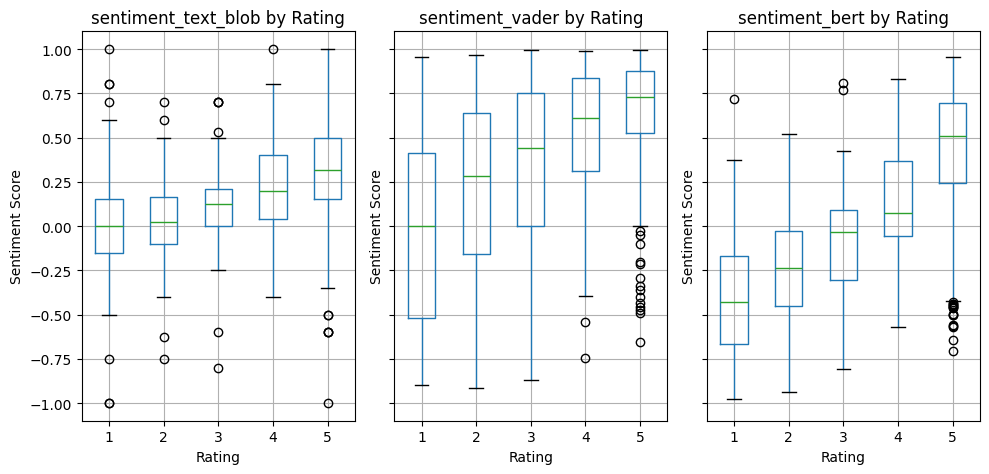

In [11]:
import matplotlib.pyplot as plt

# Plotting box plots for each sentiment column by rating
fig, axes = plt.subplots(1, len(sentiment_columns), figsize=(10, 5), sharey=True)

for i, column in enumerate(sentiment_columns):
    df.boxplot(column=column, by='rating', ax=axes[i])
    axes[i].set_title(f'{column} by Rating')
    axes[i].set_xlabel('Rating')
    axes[i].set_ylabel('Sentiment Score')

plt.suptitle('')  # Suppress the overall title to focus on individual plots
plt.tight_layout()
plt.show()


## Bert seems the most natural fit, but it seems to have higher computational requirements, so we will use vader for our use case
See sentiment_processing.py

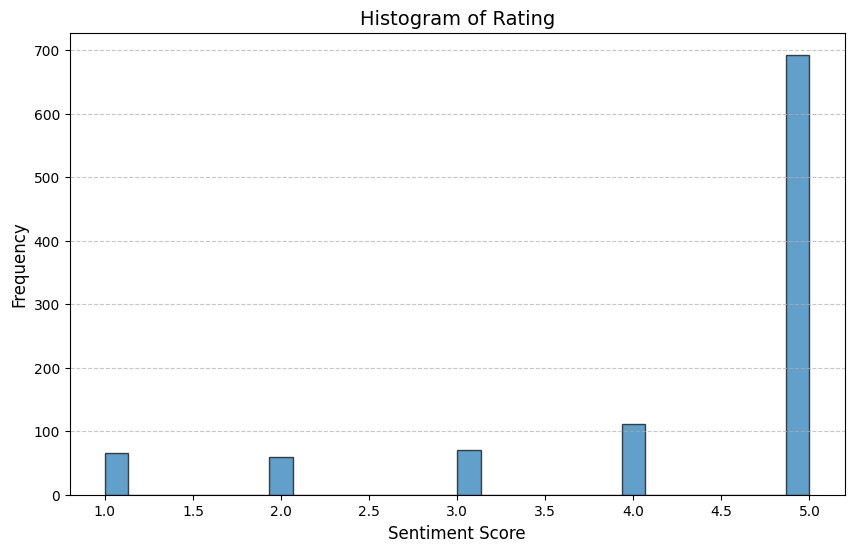

In [16]:
import matplotlib.pyplot as plt

# Create a histogram for the 'sentiment_vader' column
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(df['rating'], bins=30, edgecolor='black', alpha=0.7)  # Plot histogram
plt.title('Histogram of Rating', fontsize=14)  # Add a title
plt.xlabel('Sentiment Score', fontsize=12)  # Label the x-axis
plt.ylabel('Frequency', fontsize=12)  # Label the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid for the y-axis
plt.show()  # Display the plot


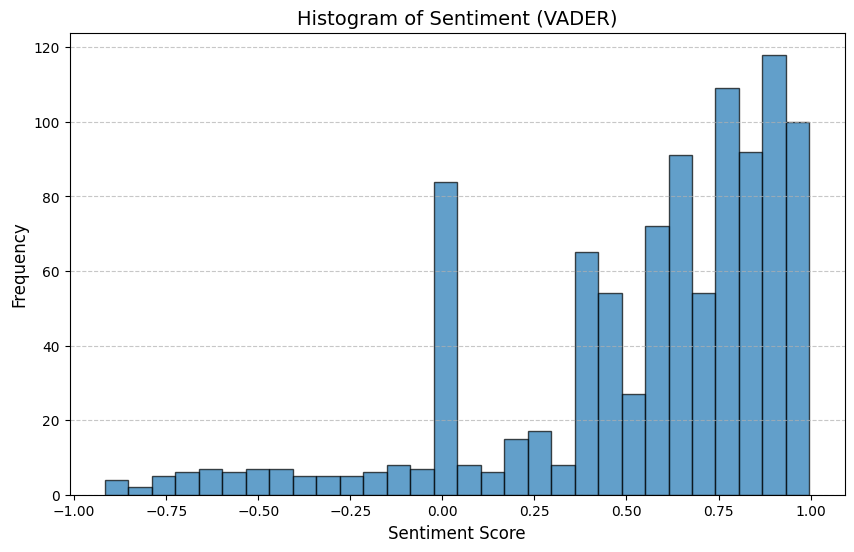

In [12]:
import matplotlib.pyplot as plt

# Create a histogram for the 'sentiment_vader' column
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(df['sentiment_vader'], bins=30, edgecolor='black', alpha=0.7)  # Plot histogram
plt.title('Histogram of Sentiment (VADER)', fontsize=14)  # Add a title
plt.xlabel('Sentiment Score', fontsize=12)  # Label the x-axis
plt.ylabel('Frequency', fontsize=12)  # Label the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid for the y-axis
plt.show()  # Display the plot


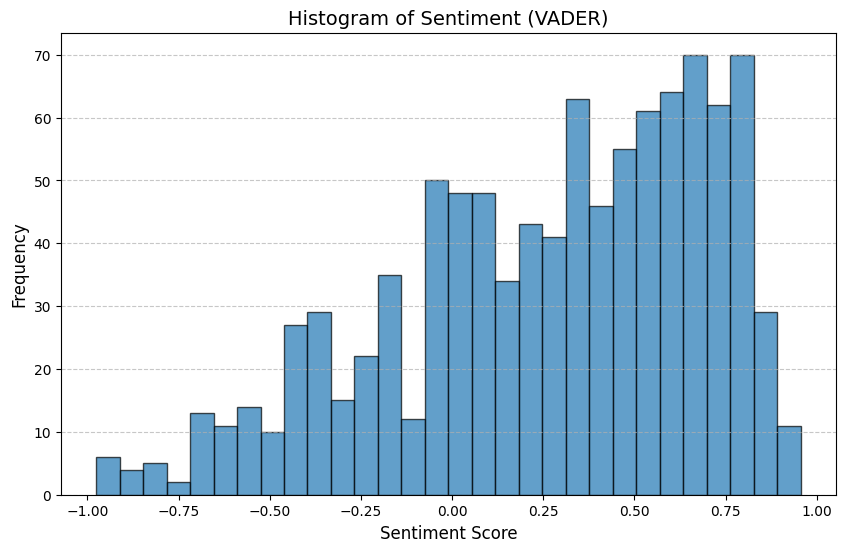

In [13]:
import matplotlib.pyplot as plt

# Create a histogram for the 'sentiment_vader' column
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(df['sentiment_bert'], bins=30, edgecolor='black', alpha=0.7)  # Plot histogram
plt.title('Histogram of Sentiment (BERT)', fontsize=14)  # Add a title
plt.xlabel('Sentiment Score', fontsize=12)  # Label the x-axis
plt.ylabel('Frequency', fontsize=12)  # Label the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid for the y-axis
plt.show()  # Display the plot


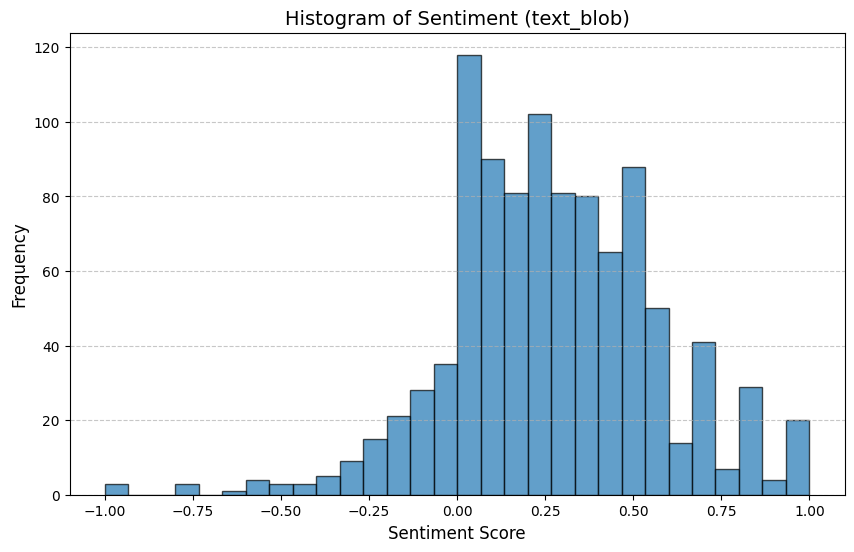

In [14]:
import matplotlib.pyplot as plt

# Create a histogram for the 'sentiment_vader' column
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(df['sentiment_text_blob'], bins=30, edgecolor='black', alpha=0.7)  # Plot histogram
plt.title('Histogram of Sentiment (text_blob)', fontsize=14)  # Add a title
plt.xlabel('Sentiment Score', fontsize=12)  # Label the x-axis
plt.ylabel('Frequency', fontsize=12)  # Label the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid for the y-axis
plt.show()  # Display the plot
